In [1]:
# ML Pipeline Notebook

## 1. Setup and Imports

import sys
from pathlib import Path

# Add project root to Python path
project_root = str(Path.cwd().parent)
if project_root not in sys.path:
    sys.path.append(project_root)

# Import your modules
import yaml
import pandas as pd
import numpy as np
from rich import print
from IPython.display import display
from src.data.data_processing import DataAnalyzer, DataProcessor
from src.features.feature_engineering import FeatureMetadata
from src.models.model_training import ModelTrainer

# Load configuration
with open('configs/config.yml', 'r') as f:
    config = yaml.safe_load(f)


## 2. Data Loading and Initial Processing

# Initialize DataProcessor
data_processor = DataProcessor('configs/config.yml')

# Load raw data
raw_data_path = data_processor.config['data']['raw_data_path']
raw_data_file_name = data_processor.config['data']['raw_data_file_name']

# 1) Load data and change columns data type
raw_data_df = data_processor.data_load(f'{raw_data_path}{raw_data_file_name}')

print('Initial raw data:')
display(raw_data_df.head())
print('\nInitial raw data shape:', raw_data_df.shape)


DATA LOADING: Inferring data types based on first 3000 rows...

DATA LOADING: Data types inferred count
 object    3
int64     1
Name: count, dtype: int64

Initial raw data:

,tweet_id,from_platform,sentiment,tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


Initial raw data shape:
(74682, 4)

Complete processing of all features: handling missing values, outliers, scaling, vectorize text colums, encoding categorials features, etc..

In [2]:
## 3. Data Preprocessing and Feature Engineering
if raw_data_df is not None:

    # --- TRAINING DATA PROCESSING ---
    # We explicitly pass `is_prediction=False` so that
    # TF-IDF, scalers, etc. are *fitted* on these data.
    data_preprocessed_df = data_processor.process_data(
        raw_data_df,
        data_file_name=raw_data_file_name,
        is_prediction=False  # <--- key update
    )
    
    if data_preprocessed_df is not None:
        print("Training data preprocessing completed successfully")
        display(data_preprocessed_df.head())

        # (Optional) Save the fitted TF-IDF vectorizer to a file
        data_processor.save_vectorizer("models/tfidf_vectorizer.joblib")

        print('\n--- PROCESSING TEST DATA ---')

        raw_data_test_file_name = config['data']['raw_data_test_file_name']

        if raw_data_test_file_name:
            # CASE 1: There's a separate test file
            print(f"\nProcessing separate test file: {raw_data_test_file_name}")
            
            raw_data_test_df = data_processor.data_load(f'{raw_data_path}/{raw_data_test_file_name}')
            
            if raw_data_test_df is not None:
                # Now load the previously fitted vectorizer (optional, if you want to be explicit):
                data_processor.load_vectorizer("models/tfidf_vectorizer.joblib")

                # Process test data with is_prediction=True => transform only
                data_test_preprocessed_df = data_processor.process_data(
                    raw_data_test_df,
                    data_file_name=raw_data_test_file_name,
                    is_prediction=False
                )
                
                if data_test_preprocessed_df is not None:
                    print("Test data preprocessing completed successfully")
                    display(data_test_preprocessed_df.head())
                else:
                    print('Test data preprocessing failed')
            else:
                print('Test data loading failed')
        else:
            # CASE 2: No separate test file => Split from the training data
            print("\nNo separate test file. Creating test data from training data...")

            from sklearn.model_selection import train_test_split
            test_size = config.get('model', {}).get('params', {}).get('test_size', 0.2)
            random_state = config.get('model', {}).get('params', {}).get('random_state', 42)

            # We already 'fit' everything on data_preprocessed_df
            # so *this* DataFrame is *already processed*
            # => we can just do the train_test_split for final usage
            train_df, test_df = train_test_split(
                data_preprocessed_df,
                test_size=test_size,
                random_state=random_state
            )

            print("\nSaving split datasets...")

            # Save the training portion
            data_processor.save_processed_data(train_df, raw_data_file_name)
            print(f"Training data saved successfully")

            # Save the test portion
            import os
            file_name, file_extension = os.path.splitext(raw_data_file_name)
            test_file_name = f"{file_name}_test{file_extension}"

            data_processor.save_processed_data(test_df, test_file_name)
            print(f"Test data saved successfully")

            # Assign the final references
            data_preprocessed_df = train_df
            data_test_preprocessed_df = test_df

            print(f"\nFinal shapes:")
            print(f"Training data: {train_df.shape}")
            print(f"Test data: {test_df.shape}")

    else:
        print('Training data preprocessing failed')
else:
    print('Data loading failed')


DATA PROCESS: Missing values in numeric cols:
 tweet_id    0
dtype: int64

DATA PROCESS: Missing numeric after fill:
 tweet_id    0
dtype: int64

DATA PROCESS: Categorical cols:
 Index(['from_platform', 'sentiment', 'tweet'], dtype='object')

DATA PROCESS: After handling missing values:
        tweet_id from_platform sentiment  \
0          2401   Borderlands  Positive   
1          2401   Borderlands  Positive   
2          2401   Borderlands  Positive   
3          2401   Borderlands  Positive   
4          2401   Borderlands  Positive   
...         ...           ...       ...   
74677      9200        Nvidia  Positive   
74678      9200        Nvidia  Positive   
74679      9200        Nvidia  Positive   
74680      9200        Nvidia  Positive   
74681      9200        Nvidia  Positive   

                                                   tweet  
0      im getting on borderlands and i will murder yo...  
1      I am coming to the borders and I will kill you...  
2      im getting on borderlands and i will kill you ...  
3      im coming on borderlands and i will murder you...  
4      im getting on borderlands 2 and i will murder ...  
...                                                  ...  
74677  Just realized that the Windows partition of my...  
74678  Just realized that my Mac window partition is ...  
74679  Just realized the windows partition of my Mac ...  
74680  Just realized between the windows partition of...  
74681  Just like the windows partition of my Mac is l...  

[74682 rows x 4 columns]

DATA PROCESS: row_data_column_id_index:
 -1

DATA PROCESS: No valid ID col to drop or none specified.

[nltk_data] Downloading package punkt to /Users/mdabo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/mdabo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/mdabo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/mdabo/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


DATA PROCESS (vectorization): Processing column 'tweet'...

DATA PROCESS (vectorization): Created 50 features.

DATA PROCESS: Numeric cols to scale =>  Index(['tweet_id', 'tweet_feature_amazon', 'tweet_feature_back',
       'tweet_feature_best', 'tweet_feature_ca', 'tweet_feature_day',
       'tweet_feature_dead', 'tweet_feature_even', 'tweet_feature_facebook',
       'tweet_feature_fifa', 'tweet_feature_first', 'tweet_feature_fuck',
       'tweet_feature_fucking', 'tweet_feature_game', 'tweet_feature_get',
       'tweet_feature_go', 'tweet_feature_going', 'tweet_feature_good',
       'tweet_feature_google', 'tweet_feature_got', 'tweet_feature_great',
       'tweet_feature_guy', 'tweet_feature_http', 'tweet_feature_johnson',
       'tweet_feature_know', 'tweet_feature_like', 'tweet_feature_look',
       'tweet_feature_love', 'tweet_feature_make', 'tweet_feature_microsoft',
       'tweet_feature_much', 'tweet_feature_new', 'tweet_feature_one',
       'tweet_feature_people', 'tweet_feature_play', 'tweet_feature_player',
       'tweet_feature_playing', 'tweet_feature_please', 'tweet_feature_really',
       'tweet_feature_red', 'tweet_feature_see', 'tweet_feature_shit',
       'tweet_feature_still', 'tweet_feature_time', 'tweet_feature_today',
       'tweet_feature_unk', 'tweet_feature_verizon', 'tweet_feature_want',
       'tweet_feature_would', 'tweet_feature_xbox', 'tweet_feature_year'],
      dtype='object')

DATA PROCESS: No main features to weight, skipping.

DATA PROCESS: Categorical columns to encode =>
['from_platform', 'sentiment']

DATA PROCESS: Processed data saved successfully!

Training data preprocessing completed successfully

,tweet_id,tweet_feature_amazon,tweet_feature_back,tweet_feature_best,tweet_feature_ca,tweet_feature_day,tweet_feature_dead,tweet_feature_even,tweet_feature_facebook,tweet_feature_fifa,...,tweet_feature_time,tweet_feature_today,tweet_feature_unk,tweet_feature_verizon,tweet_feature_want,tweet_feature_would,tweet_feature_xbox,tweet_feature_year,from_platform_categorical_encoded,sentiment_categorical_encoded
0,-1.077848,-0.15306,-0.150595,-0.173573,-0.144926,-0.164691,-0.157454,-0.161788,-0.155673,-0.145816,...,-0.203296,-0.139249,-0.188097,-0.153392,-0.142047,-0.146367,-0.152898,-0.162519,4,3
1,-1.077848,-0.15306,-0.150595,-0.173573,-0.144926,-0.164691,-0.157454,-0.161788,-0.155673,-0.145816,...,-0.203296,-0.139249,-0.188097,-0.153392,-0.142047,-0.146367,-0.152898,-0.162519,4,3
2,-1.077848,-0.15306,-0.150595,-0.173573,-0.144926,-0.164691,-0.157454,-0.161788,-0.155673,-0.145816,...,-0.203296,-0.139249,-0.188097,-0.153392,-0.142047,-0.146367,-0.152898,-0.162519,4,3
3,-1.077848,-0.15306,-0.150595,-0.173573,-0.144926,-0.164691,-0.157454,-0.161788,-0.155673,-0.145816,...,-0.203296,-0.139249,-0.188097,-0.153392,-0.142047,-0.146367,-0.152898,-0.162519,4,3
4,-1.077848,-0.15306,-0.150595,-0.173573,-0.144926,-0.164691,-0.157454,-0.161788,-0.155673,-0.145816,...,-0.203296,-0.139249,-0.188097,-0.153392,-0.142047,-0.146367,-0.152898,-0.162519,4,3


DATA PROCESS: TF-IDF vectorizer saved to models/tfidf_vectorizer.joblib

--- PROCESSING TEST DATA ---

No separate test file. Creating test data from training data...

Saving split datasets...

DATA PROCESS: Processed data saved successfully!

Training data saved successfully

DATA PROCESS: Processed data saved successfully!

Test data saved successfully

Final shapes:

Training data: (59745, 53)

Test data: (14937, 53)

PREPARE VALIDATION DATA: LOAD AND PROCESS RAW DATA TEST FILE IF EXIST or SPLIT DATA PROCESSED IN TWO PARTS (one for the train another for the test)

DATA ANALYSE: number of features analyzed => 53

DATA ANALYSE: generating summary...

Data summary after process and analysis:

{
    'dataset_shape': (59745, 53),
    'total_missing': 0,
    'numeric_features': 53,
    'categorical_features': 0,
    'feature_stats': {
        'tweet_id': {
            'name': 'tweet_id',
            'dtype': 'numeric',
            'missing_values_count': 0,
            'unique_values_count': 12447,
            'numeric_stats': {
                'mean': -0.0010217750631760618,
                'std': 1.0009204898571122,
                'min': -1.719490242511502,
                'max': 1.8092740665500164,
                'skew': 0.03688725847779082,
                'kurtosis': -1.1608806077908795,
                'median': -0.007107834788263529
            },
            'categorical_stats': None
        },
        'tweet_feature_amazon': {
            'name': 'tweet_feature_amazon',
            'dtype': 'numeric',
            'missing_values_count': 0,
            'unique_values_count': 438,
            'numeric_stats': {
                'mean': 0.0024385253207872873,
                'std': 1.0090611108661567,
                'min': -0.15306041923414823,
                'max': 8.416055752877977,
                'skew': 6.787760210355833,
                'kurtosis': 46.64492188789452,
                'median': -0.15306041923414823
            },
            'categorical_stats': None
        },
        'tweet_feature_back': {
            'name': 'tweet_feature_back',
            'dtype': 'numeric',
            'missing_values_count': 0,
            'unique_values_count': 763,
            'numeric_stats': {
                'mean': 0.001773884764558034,
                'std': 1.0081989603088872,
                'min': -0.15059530099710314,
                'max': 10.028077002495152,
                'skew': 7.093917958131687,
                'kurtosis': 52.52049797723032,
                'median': -0.15059530099710314
            },
            'categorical_stats': None
        },
        'tweet_feature_best': {
            'name': 'tweet_feature_best',
            'dtype': 'numeric',
            'missing_values_count': 0,
            'unique_values_count': 592,
            'numeric_stats': {
                'mean': -2.3784120586430765e-05,
                'std': 0.9983077772139214,
                'min': -0.17357335101153962,
                'max': 7.538423602121443,
                'skew': 6.026642838994811,
                'kurtosis': 36.61060243324633,
                'median': -0.17357335101153962
            },
            'categorical_stats': None
        },
        'tweet_feature_ca': {
            'name': 'tweet_feature_ca',
            'dtype': 'numeric',
            'missing_values_count': 0,
            'unique_values_count': 563,
            'numeric_stats': {
                'mean': -0.001131441185974966,
                'std': 0.9954508879774173,
                'min': -0.14492572854867666,
                'max': 9.49449761520479,
                'skew': 7.35059422434951,
                'kurtosis': 55.661909414917936,
                'median': -0.14492572854867666
            },
            'categorical_stats': None
        },
        'tweet_feature_day': {
            'name': 'tweet_feature_day',
            'dtype': 'numeric',
            'missing_values_count': 0,
            'unique_values_count': 773,
            'numeric_stats': {
                'mean': -0.0014096246790990265,
                'std': 0.9957839709525493,
                'min': -0.16469144866063407,
                'max': 9.031058257210185,
                'skew': 6.552574486934787,
                'kurtosis': 44.789936543850956,
                'median': -0.16469144866063407
            },
            'categorical_stats': None
        },
        'tweet_feature_dead': {
            'name': 'tweet_feature_dead',
            'dtype': 'numeric',
            'missing_values_count': 0,
            'unique_values_count': 515,
            'numeric_stats': {
                'mean': -0.0016682776586623854,
                'std': 0.9960806616390486,

DATA ANALYSE: Too many features to plot correlation. Limiting to 10 randomly.

DATA ANALYSE: features_names to plot =>
 ['tweet_feature_best' 'tweet_feature_unk' 'tweet_feature_today'
 'tweet_feature_like' 'tweet_feature_fucking' 'tweet_feature_even'
 'tweet_feature_make' 'tweet_feature_year' 'tweet_feature_great'
 'tweet_feature_love']

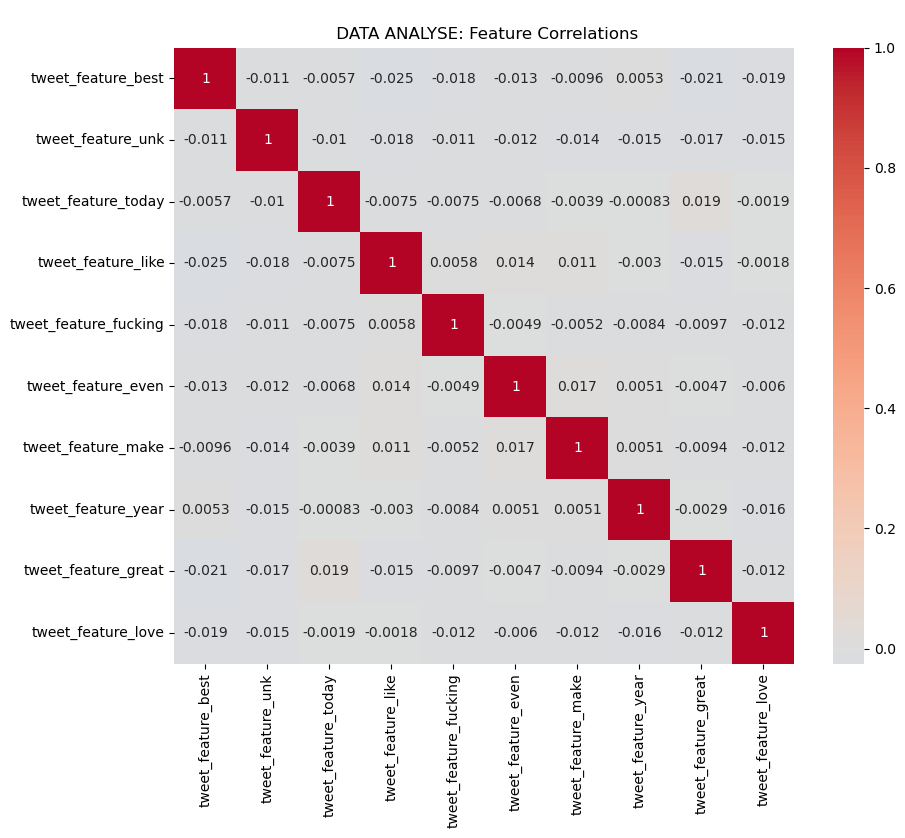

In [3]:
## 4. Data Analysis and Insights

# Initialize analyzer
data_analyser = DataAnalyzer(data_preprocessed_df)

# Generate and display summary
summary = data_analyser.generate_summary()
print('\nData summary after process and analysis:')
print(summary)

# Plot correlations
data_analyser.plot_correlations()

In [4]:
## 5. Model Training Preparation

# Prepare X, y
target_column_name = data_processor.config['data']['raw_data_target_column']['name']
target_column_type = data_processor.config['data']['raw_data_target_column']['type']

# If the target was categorical, we've turned it into <target>_categorical_encoded
if target_column_type == 'categorical':
    target_column_name = f'{target_column_name}_categorical_encoded'

if target_column_name in data_preprocessed_df.columns:
    X = data_preprocessed_df.drop(columns=[target_column_name])
    y = data_preprocessed_df[target_column_name]
else:
    X = data_preprocessed_df
    y = None

print("Features shape:", X.shape)
if y is not None:
    print("Target shape:", y.shape)
else:
    print("No target => Unsupervised scenario.")

Features shape:
(59745, 52)

Target shape:
(59745,)